# Desafio 3 - Koller Tomas

## Consigna

- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


---

In [19]:
import random
import io
import pickle
import json
import bs4 as bs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical, pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, GRU
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

### Seleccion del dataset y preprocesamiento

Para entrenar el modelo se va a utilizar el libro "Veinte mil leguas de viaje submarino" de Julio Verne

Se descarga el libro

In [37]:
raw_html = urllib.request.urlopen('https://www.textos.info/homero/odisea/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [38]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

' háblame, musa, de aquel varón de multiforme ingenio que, después de \ndestruir la sacra ciudad de troya, anduvo peregrinando larguísimo \ntiempo, vio las poblaciones y conoció las costumbres de muchos hombres y\n padeció en su ánimo gran número de trabajos en su navegación por el \nponto, en cuanto procuraba salvar su vida y la vuelta de sus compañeros a\n la patria. mas ni aun así pudo librarlos, como deseaba, y todos \nperecieron por sus propias locuras. ¡insensatos! comiéronse las vacas de\n helios, hijo de hiperión; el cual no permitió que les llegara el día \ndel regreso. ¡oh diosa, hija de zeus!, cuéntanos aunque no sea más que \nuna parte de tales cosas. ya en aquel tiempo los que habían podido escapar de una muerte \nhorrorosa estaban en sus hogares, salvos de los peligros de la guerra y \ndel mar; y solamente odiseo, que tan gran necesidad sentía de \nrestituirse a su patria y ver a su consorte, hallábase detenido en hueca\n gruta por calipso, la ninfa veneranda, la divina e

Se define un contexto de 100 palabras

In [39]:
# seleccionamos el tamaño de contexto
max_context_size = 100

Se arma el vocabulario como el conjunto de caracteres unicos que hay en libro. Se lo ordena para que ante diferentes ejecuciones de la notebook se mantenga siempre el mismo.

In [40]:
chars_vocab = sorted(set(article_text))  # orden fijo

In [41]:
len(chars_vocab)

58

In [42]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

In [43]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [44]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [45]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text   = tokenized_text[-num_val*max_context_size:]

In [46]:
tokenized_sentences_val = [
    val_text[init*max_context_size : (init+1)*max_context_size]
    for init in range(num_val)
]

In [49]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [48]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

In [50]:
vocab_size = len(chars_vocab)

### Creacion de los modelos

Hacemos 2 modelos, uno con GRU y otro con SimpleRNN

In [51]:
model_gru = Sequential()

model_gru.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_gru.add(GRU(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_gru.add(Dense(vocab_size, activation='softmax'))
model_gru.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_gru.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_4              │ (None, None, 58)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, None, 100)      │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, None, 58)       │         5,858 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,858 (210.38 KB)

 Trainable params: 53,858 (210.38 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model_simple_rnn = Sequential()

model_simple_rnn.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_simple_rnn.add(SimpleRNN(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_simple_rnn.add(Dense(vocab_size, activation='softmax'))
model_simple_rnn.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_simple_rnn.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_5              │ (None, None, 58)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, None, 100)      │        15,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, None, 58)       │         5,858 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,758 (84.99 KB)

 Trainable params: 21,758 (84.99 KB)

 Non-trainable params: 0 (0.00 B)

El callback original provisto por la cátedra generaba problemas de memoria al entrenar el modelo con GRU, lo que provocaba que al finalizar el primer epoch la computadora se congelara. Para resolverlo, se realizaron ajustes que reducen la cantidad de subsecuencias evaluadas y evitan la creación de estructuras de datos demasiado grandes, reordenando el cálculo de la perplejidad para hacerlo más eficiente. Estos cambios preservan la lógica del callback original pero permiten ejecutar el entrenamiento sin fallos. Para implementarlos y validar el enfoque se utilizó ChatGPT como apoyo.

In [53]:
class PplCallback(keras.callbacks.Callback):
    '''
    Mismo objetivo que el callback provisto:
    - Calcula perplejidad en validación al final de cada epoch
    - Hace early stopping con paciencia `patience`
    Pero procesa las predicciones en batches para no explotar memoria.
    '''

    def __init__(self, val_data, history_ppl,model_name, max_context_size, patience=5, batch_size=256):
        super().__init__()
        self.val_data = val_data
        self.history_ppl = history_ppl
        self.patience = patience
        self.batch_size = batch_size
        self.max_context_size = max_context_size
        self.model_name = model_name

        self.target = []
        padded_list = []
        self.info = []           # (start_idx, end_idx) por secuencia
        count = 0

        # Construimos subsecuencias + targets
        for seq in self.val_data:
            len_seq = len(seq)
            # subsecuencias prefijo: seq[:1], seq[:2], ..., seq[:len_seq-1]
            subseq = [seq[:i] for i in range(1, len_seq)]
            self.target.extend([seq[i] for i in range(1, len_seq)])

            if len(subseq) != 0:
                padded_seq = pad_sequences(
                    subseq,
                    maxlen=self.max_context_size,
                    padding='pre'
                )
                padded_list.append(padded_seq)
                # guardamos rango de índices globales para esta secuencia
                # OJO: usamos len(subseq), no len_seq, para ser consistentes
                start = count
                end   = count + len(subseq)
                self.info.append((start, end))
                count = end

        # Apilamos todas las subsecuencias paddeadas
        self.padded = np.vstack(padded_list)

        # Mapeo de índice de subsecuencia -> índice de secuencia original
        self.num_seqs = len(self.info)
        self.seq_for_idx = np.empty(len(self.padded), dtype=np.int32)
        for seq_id, (start, end) in enumerate(self.info):
            self.seq_for_idx[start:end] = seq_id

        # Para early stopping
        self.min_score = np.inf
        self.patience_counter = 0

        print(f"[PplCallback] padded shape: {self.padded.shape}, num_val_seqs: {self.num_seqs}")

    def on_epoch_end(self, epoch, logs=None):
        # Acumuladores por secuencia
        logprob_sum = np.zeros(self.num_seqs, dtype=np.float64)
        count_tok   = np.zeros(self.num_seqs, dtype=np.int64)

        N = len(self.padded)
        # Recorremos self.padded en batches
        for start_idx in range(0, N, self.batch_size):
            end_idx = min(start_idx + self.batch_size, N)
            xb = self.padded[start_idx:end_idx]

            # Predicciones para este batch
            preds = self.model(xb, training=False).numpy()  # shape: (B, T, vocab)

            # Usamos SOLO el último timestep como en el callback original
            preds_last = preds[:, -1, :]  # shape: (B, vocab_size)

            # Índices globales de subsecuencia para este batch
            global_idx = np.arange(start_idx, end_idx)
            # tokens target correspondientes
            target_batch = np.array(self.target[start_idx:end_idx], dtype=np.int32)
            # secuencia original a la que pertenece cada subsecuencia
            seq_ids = self.seq_for_idx[global_idx]

            # Probabilidades de los tokens target
            probs = preds_last[np.arange(len(target_batch)), target_batch]
            # Evitamos log(0)
            probs = np.clip(probs, 1e-12, 1.0)

            # Acumulamos log-probabilidad por secuencia
            np.add.at(logprob_sum, seq_ids, np.log(probs))
            np.add.at(count_tok,   seq_ids, 1)

        # Calculamos perplejidad por secuencia y promedio
        scores = []
        for s in range(self.num_seqs):
            if count_tok[s] > 0:
                avg_logprob = logprob_sum[s] / count_tok[s]
                scores.append(np.exp(-avg_logprob))

        current_score = float(np.mean(scores))
        self.history_ppl.append(current_score)
        print(f"\n mean perplexity: {current_score:.4f} \n")

        # Early stopping igual que antes
        if current_score < self.min_score:
            self.min_score = current_score
            self.model.save(f"my_model_{self.model_name}.keras")
            print("Saved new model!")
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter == self.patience:
                print("Stopping training...")
                self.model.stop_training = True

### Entrenamiento de los modelos

Se entrena el modelo que utiliza GRU

In [54]:
history_ppl_gru = []

ppl_cb = PplCallback(
    val_data=tokenized_sentences_val,
    history_ppl=history_ppl_gru,
    model_name='gru',
    max_context_size=max_context_size,
    patience=3,
    batch_size=256
)


hist_gru = model_gru.fit(
    X, y,
    epochs=5,
    batch_size=256,
    callbacks=[ppl_cb]
)

[PplCallback] padded shape: (67518, 100), num_val_seqs: 682
Epoch 1/5
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 2.3880
 mean perplexity: 6.1075 

Saved new model!
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 926s 384ms/step - loss: 2.3879
Epoch 2/5
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 1.8294
 mean perplexity: 5.2666 

Saved new model!
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 909s 380ms/step - loss: 1.8294
Epoch 3/5
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 1.7128
 mean perplexity: 4.9515 

Saved new model!
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 911s 380ms/step - loss: 1.7128
Epoch 4/5
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 1.6582
 mean perplexity: 4.8154 

Saved new model!
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 907s 379ms/step - loss: 1.6582
Epoch 5/5
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 1.6259
 mean perplexity: 4.7169 

Saved new model!
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 929s 381ms/step - loss: 1.6259


Se observa la gráfica de como disminuye la perplejidad a medida que avanza el entrenamiento

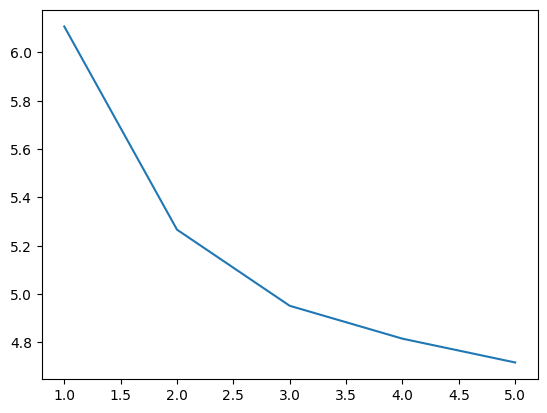

In [55]:
epoch_count = range(1, len(history_ppl_gru) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_gru)
plt.show()

Se entrena el modelo que utiliza SimpleRNN

In [60]:
history_ppl_srnn = []

ppl_cb = PplCallback(
    val_data=tokenized_sentences_val,
    history_ppl=history_ppl_srnn,
    model_name='simple_rnn',
    max_context_size=max_context_size,
    patience=3,
    batch_size=256
)


hist_srnn= model_simple_rnn.fit(
    X, y,
    epochs=5,
    batch_size=256,
    callbacks=[ppl_cb]
)

[PplCallback] padded shape: (67518, 100), num_val_seqs: 682
Epoch 1/5
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.3507
 mean perplexity: 6.3035 

Saved new model!
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 128s 53ms/step - loss: 2.3507
Epoch 2/5
2395/2396 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9469
 mean perplexity: 5.7996 

Saved new model!
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 124s 52ms/step - loss: 1.9469
Epoch 3/5
2394/2396 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8926
 mean perplexity: 5.6158 

Saved new model!
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 122s 51ms/step - loss: 1.8926
Epoch 4/5
2395/2396 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8680
 mean perplexity: 5.5481 

Saved new model!
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 122s 51ms/step - loss: 1.8680
Epoch 5/5
2394/2396 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8535
 mean perplexity: 5.4788 

Saved new model!
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 123s 51ms/step - loss: 1.8535


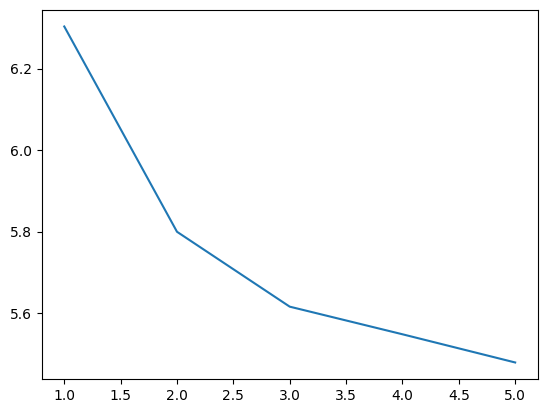

In [61]:
# Entrenamiento
epoch_count = range(1, len(history_ppl_srnn) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_srnn)
plt.show()

Se observa una diferencia clara en los tiempos de entrenamiento entre ambos modelos. El modelo basado en GRU requirió aproximadamente 76 minutos, mientras que la versión con SimpleRNN tardó cerca de 15 minutos. Esto se debe a que una unidad GRU incorpora más parámetros y operaciones internas que una celda SimpleRNN, lo cual incrementa el costo computacional por epoch.

### Evaluacion de los modelos

In [75]:
# Cargamos los mejores modelos guardados durante el entrenamiento
model_gru = keras.models.load_model('my_model_gru.keras')
model_simple_rnn = keras.models.load_model('my_model_simple_rnn.keras')

#### Se definen las funciones que se van a utilizar para probar los modelos

In [76]:
def greedy_search(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [77]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [78]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

#### Se realizar pruebas sobre ambos modelos con diferentes casos y combinaciones


Para todos los casos se va a utilizart el siguiente texto como input y se va a esperar que devuelvan un total de 100 caracteres

In [79]:
input_text='primero en hablar el padre de los hombres'

### Prueba de Greedy Search

In [80]:
greedy_search(model_simple_rnn, input_text, max_length=max_context_size, n_words=100)

'primero en hablar el padre de los hombres de la casa de la casa de la casa de la casa de la casa de la casa de la casa de la casa de la casa '

In [81]:
greedy_search(model_gru, input_text, max_length=max_context_size, n_words=100)

'primero en hablar el padre de los hombres de la casa de la casa de la casa de la casa de la casa de la casa de la casa de la casa de la casa '

Greedy Search elige siempre el carácter de mayor probabilidad, por lo que tiende a “atascarse” en bucles locales. En este caso, ambos modelos convergen inmediatamente a repeticiones de la frase “de la casa”, lo cual indica:

Fuerte dependencia de patrones frecuentes del corpus.

Incapacidad para salir de secuencias de alta probabilidad repetitiva.

Coherencia sintáctica mínima, pero sin diversidad.

Ambos modelos (SimpleRNN y GRU) colapsan a la misma estructura.

Este comportamiento es esperable: Greedy Search suele producir texto monótono y altamente repetitivo.

#### Prueba de Beam Search con 2 beams y modo deterministico

In [90]:
salidas = beam_search(model_simple_rnn,num_beams=2,num_words=100,input=input_text,temp=1,mode='det')
decode(salidas[0])

'primero en hablar el padre de los hombres de los dioses de los dioses de los dioses de los dioses de los dioses de los dioses de los dioses, '

In [91]:
salidas = beam_search(model_gru,num_beams=2,num_words=100,input=input_text,temp=1,mode='det')
decode(salidas[0])

'primero en hablar el padre de los hombres de los pretendientes de los pretendientes de los pretendientes de los pretendientes de los pretendi'

Con un beam pequeño (2 beams):

Aún hay repetición, pero ya no aparece “de la casa”; el modelo explora alternativas semánticamente relacionadas con el texto de origen (“dioses”, “pretendientes”).

Se ve mayor diversidad léxica respecto a greedy, aunque sigue siendo limitada.

Las secuencias siguen cayendo en repetición estructural del mismo patrón (“de los X de los X…”).

Diferencias sutiles entre modelos:

El SimpleRNN tiende más a “dioses”, un patrón muy frecuente.

GRU introduce “pretendientes”, un término del mismo universo narrativo pero menos trivial, mostrando mayor sensibilidad al contexto.

#### Prueba de Beam Search con 6 beams y modo deterministico

In [92]:
salidas = beam_search(model_simple_rnn,num_beams=6,num_words=100,input=input_text,temp=1,mode='det')
decode(salidas[0])

'primero en hablar el padre de los hombres de los pretendientes de los pretendientes de los pretendientes de los pretendientes de los compañer'

In [93]:
salidas = beam_search(model_gru,num_beams=6,num_words=100,input=input_text,temp=1,mode='det')
decode(salidas[0])

'primero en hablar el padre de los hombres de los pretendientes de los pretendientes de los pretendientes de los pretendientes de los hombres '

Al aumentar el ancho del beam a 6:

Ambos modelos convergen a la misma construcción: “de los pretendientes”.

Esto indica que el modelo considera esta secuencia muy probable bajo el contexto de entrada.

No mejora la diversidad respecto a 2 beams; de hecho, la repetición es más marcada.

El aumento del beam refuerza patrones de alta probabilidad → más coherencia local, pero menos novedad.

Aquí se observa algo típico del beam search determinístico:

“Beams más grandes producen textos más conservadores, no más creativos”.

#### Prueba de Beam Search con 4 beams, modo estocastico y temperatura de 0.8

In [94]:
salidas = beam_search(model_simple_rnn,num_beams=4,num_words=100,input=input_text,temp=0.8,mode='sto')
decode(salidas[0])

'primero en hablar el padre de los hombres de la manos las bronto de los dioses con los dioses y me había los hombres de los porque no le comp'

In [95]:
salidas = beam_search(model_gru,num_beams=4,num_words=100,input=input_text,temp=0.8,mode='sto')
decode(salidas[0])

'primero en hablar el padre de los hombres de los respondióles en la manera de los más de los hombres de los pretendientes que se la divinal o'

Con aleatoriedad moderada y temperatura < 1:

Aparece mayor diversidad, especialmente en GRU.

El texto tiene errores (“bronto”, “me había los hombres”, “se la divinal”), pero sigue una estructura fraseal reconocible.

El léxico mantiene coherencia temática: “dioses”, “hombres”, “pretendientes”.

Comparación modelos:

SimpleRNN produce frases más fragmentadas y errores más abruptos.

GRU logra encadenar partes de oración completas, aunque con desviaciones gramaticales.

Este es el primer escenario donde se observa creatividad útil, aún dentro del mundo semántico del texto original.

#### Prueba de Beam Search con 4 beams, modo estocastico y temperatura 1.2

In [96]:
salidas = beam_search(model_simple_rnn,num_beams=4,num_words=100,input=input_text,temp=1.2,mode='sto')
decode(salidas[0])

'primero en hablar el padre de los hombres y el algura de la la compañeros de la ciudad de los presente se todos en la amigo de su hijo de un '

In [97]:
salidas = beam_search(model_gru,num_beams=4,num_words=100,input=input_text,temp=1.2,mode='sto')
decode(salidas[0])

'primero en hablar el padre de los hombres que no habló a la miseramente mi mento, que está sus inificios, sin que haber el palacio con el dec'

Con un muestreo más caliente (1.2):

La creatividad aumenta notablemente.

La coherencia sintáctica cae más rápido.

Aparecen neologismos o errores severos (“algura”, “inificios”, “mi mento”), característicos de temperaturas altas.

Sin embargo, el modelo mantiene marcadores estilísticos propios del corpus:

“palacio”

“compañeros”

“ciudad”

“habló”

“hijo”

GRU produce fragmentos más largos y articulados, aunque caóticos; SimpleRNN tiende más al ruido.

Este régimen muestra la capacidad del modelo para generar variación, pero con costo de estabilidad.

### Conclusiones

En conjunto, los resultados muestran diferencias claras entre los métodos de generación y entre las arquitecturas evaluadas.

Greedy Search confirmó ser demasiado rígido: tanto el modelo SimpleRNN como el GRU colapsaron rápidamente a repeticiones del patrón “de la casa”, revelando que esta estrategia no permite explorar alternativas lingüísticas más ricas.

Con Beam Search determinista, tanto con 2 como con 6 beams, se observó una mejora parcial. Aparecen términos semánticamente coherentes con el universo narrativo del texto (“dioses”, “pretendientes”), pero también se evidencia una fuerte tendencia a repetir continuamente la misma estructura. El aumento del beam no generó mayor diversidad; por el contrario, reforzó las secuencias de mayor probabilidad, produciendo textos más conservadores.

Las configuraciones estocásticas introdujeron un comportamiento más variado. Con 4 beams y temperatura 0.8, ambas arquitecturas comenzaron a generar frases más flexibles y menos repetitivas. El modelo GRU logró secuencias más largas y coherentes, mientras que el SimpleRNN continuó mostrando fragmentación y errores frecuentes. Este escenario resultó ser el mejor equilibrio entre coherencia y diversidad.

Al elevar la temperatura a 1.2, la creatividad aumentó significativamente, pero también la inestabilidad sintáctica. Aparecieron palabras deformadas y saltos abruptos en la secuencia. A pesar de ello, el modelo GRU conservó características estilísticas del texto de origen, mientras que el SimpleRNN tendió más al ruido.

En general, la arquitectura GRU demostró una capacidad claramente superior para mantener contexto, generar frases más coherentes y seguir el estilo del corpus incluso bajo configuraciones estocásticas. El SimpleRNN, aunque funcional, mostró limitaciones marcadas tanto en estabilidad como en diversidad.

Estos experimentos confirman que:
- La elección del método de decodificación influye fuertemente en la calidad del texto generado.
- Beam Search determinista maximiza la probabilidad pero sacrifica diversidad.
- El muestreo estocástico, especialmente con temperaturas moderadas, produce los mejores resultados en equilibrio entre creatividad y coherencia.
- Las arquitecturas recurrentes más avanzadas (GRU en este caso) son más adecuadas para modelar dependencias largas y estilos narrativos complejos.
